In [385]:
img_test = cv2.cvtColor(cv2.imread("Images/test_images/straight_lines1.jpg"), cv2.COLOR_BGR2RGB)
img_size = (img_test.shape[1], img_test.shape[0])
# Undistortion Function, we just load the distortion co-efficients and undistort the image
def undistort(img):
    with open("C:/Users/lenovo/Documents/SDCND/Advanced-Lane-Finding/dist_pickle.p", "rb") as fname:
        dp = pickle.load(fname)
        mtx = dp["Camera_Matrix"] 
        dist = dp["Distortion_Coefficients"]
        dst = cv2.undistort(img, mtx, dist, None ,mtx)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
        ax1.set_title("Original Image")
        ax1.imshow(img, cmap = "gray")
        ax2.set_title("Undistorted Image")
        ax2.imshow(dst, cmap = "gray")
        return dst
# An example
#dst = undistort(img_test)

In [386]:
# Perspective Transform
def warp(dst, draw_lines = False):
    source_pts = np.array([ [195, dst.shape[0]], [597, 448], [690, 448], [1190, dst.shape[0]] ], np.float32)
    #source_pts = np.array([ [105, dst.shape[0]], [547, 448], [685, 448], [1140, dst.shape[0]] ], np.float32)
    offset = 300
    dst_pts = np.array([ [0 + offset, dst.shape[0]], [0 + offset, 0], [dst.shape[1] - offset, 0], [dst.shape[1] - offset, dst.shape[0]] ], np.float32)
    if draw_lines == True:
        cv2.line(dst, (195, dst.shape[0]), (597, 448), (255, 0, 0), 1)
        cv2.line(dst, (690, 448), (1190, dst.shape[0]), (255, 0, 0), 1)
        #cv2.line(dst, (105, dst.shape[0]), (547, 448), (255, 0, 0), 1)
        #cv2.line(dst, (685, 448), (1140, dst.shape[0]), (255, 0, 0), 1)
    M = cv2.getPerspectiveTransform(source_pts, dst_pts)
    Minv = cv2.getPerspectiveTransform(dst_pts, source_pts)
    warped_dst = cv2.warpPerspective(dst, M, (dst.shape[1], dst.shape[0]), flags = cv2.INTER_LINEAR)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
    ax1.set_title("Undistorted + Thresholded Image")
    ax1.imshow(dst, cmap = "gray")
    ax2.set_title("Undistorted + Thresholded + Warped Image")
    ax2.imshow(warped_dst, cmap = "gray")
    return warped_dst, M, Minv
#a = warp(dst)

In [390]:
def final_pipeline(image):
    undistorted_image = undistort(image)
    thresholded_image = threshold_pipeline(undistorted_image, sx_thresh = (30, 100))
    warped_image, M, Minv = warp(thresholded_image, draw_lines = False)
    binary_warped = cv2.threshold(warped_image, 50, 255, cv2.THRESH_BINARY)[1]
    return binary_warped

In [404]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline
# HERE WE DEFINE THE FUNCTIONS FOR THRESHOLDING in X Gradient, Magnitude Gradient, Direction, and Color Thresholding.
# Read in an image and grayscale it
# This function will provide a binary image thresholded based on x or y gradient values
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == "x":
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobel = np.abs(sobel)
    sobel_scaled = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(sobel_scaled)
    grad_binary[(sobel_scaled >= thresh[0]) & (sobel_scaled <= thresh[1])] = 1
    #plt.title("Sobel X Binary with Thresholds: {:.1f}, {:.1f}".format(thresh[0], thresh[1]))
    #plt.imshow(grad_binary, cmap = "gray"), plt.show()
    return grad_binary
# This function will return a binary image thresholded based on magnitude of the gradient
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    sobel_scaled = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    mag_binary = np.zeros_like(sobel_scaled)
    mag_binary[(sobel_scaled >= mag_thresh[0]) & (sobel_scaled <= mag_thresh[1])] = 1
    #plt.title("Magnitude Thresholding"),plt.imshow(mag_binary, cmap = "gray"), plt.show()
    return mag_binary
# This function will return a binary image thresholded based on orientation of gradient
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    orient = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(orient)
    dir_binary[(orient >= thresh[0]) & (orient <= thresh[1])] = 1
    #plt.title("Dir binary"), plt.imshow(dir_binary, cmap = "gray"), plt.show()
    return dir_binary
# This function returns a binary image thresholded based on white HSV value range
def white_threshold_HSV(img, lower = [0, 0, 200], upper = [255, 30, 255]):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    figures = {}
    labels = {}
    names = ["H", "S", "V"]
    for i in range(3):
        figures[i] = img_hsv[:, :, i]
        labels[i] = names[i]
    lower_white = np.array(lower, dtype = np.uint8)
    upper_white = np.array(upper, dtype = np.uint8)
    white_thresh = cv2.inRange(img_hsv, lower_white, upper_white)
    figures[3] = white_thresh
    labels[3] = "Thresh"
    #plot_thresholded(figures, 1, 4, labels)
    return white_thresh


def yellow_threshold_HLS(img, lower = [0, 0, 120], upper = [40, 255, 255]):
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    lower_yellow = np.array(lower, dtype = np.uint8)
    upper_yellow = np.array(upper, dtype = np.uint8)
    yellow_thresh = cv2.inRange(img_hls, lower_yellow, upper_yellow)
    #plt.title("Yellow thresholding in HLS")
    #plt.imshow(yellow_thresh, cmap = "gray"), plt.show()
    return yellow_thresh


# Edit this function to create your own pipeline.
def threshold_pipeline(img, sx_thresh):
    sobelx_binary = abs_sobel_thresh(img, orient = "x", sobel_kernel = 15, thresh = (sx_thresh))
    sobely_binary = abs_sobel_thresh(img, orient = "y", sobel_kernel = 15, thresh = (20, 150))
    white_binary = white_threshold_HSV(img)
    yellow_binary_HLS = yellow_threshold_HLS(img)
    mag_binary = mag_thresh(img, sobel_kernel = 3, mag_thresh = (60, 150))
    dir_binary = dir_threshold(img, sobel_kernel = 3, thresh = (0.7, 1.3) )
    combined = np.zeros_like(yellow_binary_HLS)
    combined[(white_binary == 255) | ((yellow_binary_HLS == 255)) | ((sobelx_binary == 1) & (sobely_binary==1)) | ((mag_binary == 1) & (sobelx_binary==1)) | ((mag_binary==1) & (dir_binary == 1))] = 255
    return combined
    



C:/Users/lenovo/Documents/SDCND/Advanced-Lane-Finding/Images/test_images\yellow_lanes.jpg
(333, 593)
0


ValueError: could not broadcast input array from shape (333,593) into shape (720,1280)

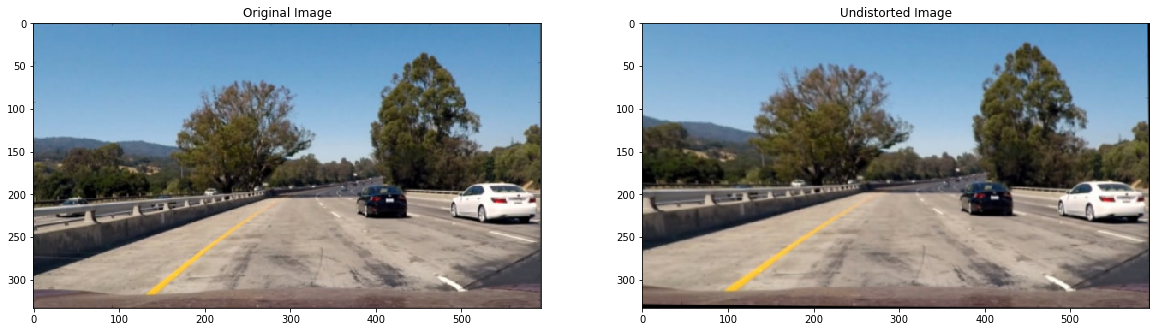

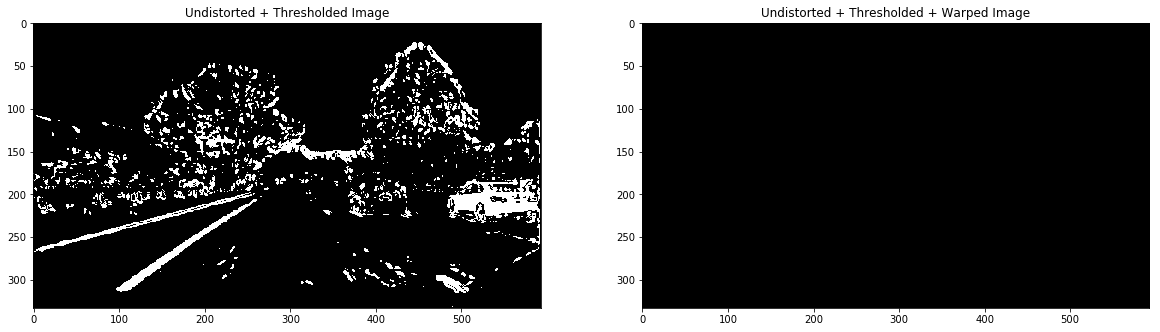

In [439]:
# Test undistortion and warping on thresholded images
import matplotlib.image as mpimg
import time

imagepaths = glob.glob("C:/Users/lenovo/Documents/SDCND/Advanced-Lane-Finding/Images/test_images/*.jpg")
imstack = np.zeros( (720, 1280, len(imagepaths)))
for k, fname in enumerate(imagepaths):
    print(fname)
    image = mpimg.imread(fname)
    binary_warped = final_pipeline(image)
    print(binary_warped.shape)
    print(k)
    imstack[:, :, k-1] = binary_warped
    
    #break
    

[ 17.  14.  14. ...,  30.  29.  30.]


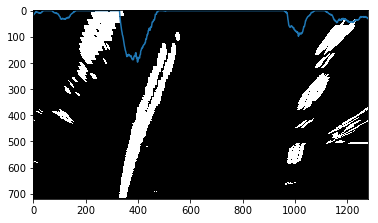

([<matplotlib.lines.Line2D at 0x26219f0ec50>], None)

In [435]:
warped = binary_warped
histogram = np.sum(warped[warped.shape[0] // 2:, :], axis = 0)/255
print(histogram)
plt.imshow(warped, cmap = "gray")
plt.plot(histogram), plt.show()

398
1013
The radius of curvature is: 2687.84178825 m 409.863603999 m


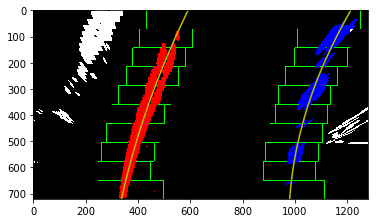

In [446]:
# Sliding Window Method
# This involves defining a window (rectangle) for each lane. Which starts at the bottom and slides to the top of the lane. 
# After each slide. We recalculate the center of the window, using the average x co-ordinate of the non-zero pixels
# within the window.
def find_lane_lines_new_fit(warped):
    # First define an output image, on which we can visualize the windows and lanes
    output_image = np.dstack((warped, warped, warped)) # 3 channel image
    # Next we have to define the midpoint for each lane.
    midpoint = np.int(warped.shape[1] / 2)
    leftx_mid = np.argmax(histogram[:midpoint])
    rightx_mid = np.argmax(histogram[midpoint:]) + midpoint
    print(leftx_mid), print(rightx_mid)
    # Let us define what a window is
    nWindows = 10 # This can be adjusted
    window_height = np.int(warped.shape[0] / nWindows)
    margin = 100 # this can be adjusted

    # Let us get all x and y co-ordinates of non zero pixels
    non_zero = warped.nonzero()
    non_zeroy = np.array(non_zero[0])
    non_zerox = np.array(non_zero[1])

    # Current positions of windows, these will be updated once we find a windows with a min number of pixels
    leftx_current = leftx_mid
    rightx_current = rightx_mid
    min_pixel = 50 # this can be adjusted

    # Empty lists to store the left and right lanes indices
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nWindows):
        # Define window boundaries
        window_ylow = warped.shape[0] - (window + 1)*(window_height)
        window_yhigh = warped.shape[0] - (window)*(window_height)
        window_xleft_low = leftx_current - margin    
        window_xleft_high = leftx_current + margin
        window_xright_low = rightx_current - margin
        window_xright_high = rightx_current + margin
        # Draw the windows on the output image
        cv2.rectangle(output_image,(window_xleft_low,window_ylow),(window_xleft_high,window_yhigh),
        (0,255,0), 2) 
        cv2.rectangle(output_image,(window_xright_low,window_ylow),(window_xright_high,window_yhigh),
        (0,255,0), 2) 
        # Find the left and right non zero indices which are in each of the windows
        good_left_inds = ((non_zeroy >= window_ylow) & (non_zeroy < window_yhigh) & 
                         (non_zerox >= window_xleft_low) &  (non_zerox < window_xleft_high)).nonzero()[0]
    
        good_right_inds = ((non_zeroy >= window_ylow) & (non_zeroy < window_yhigh) &
                          (non_zerox >= window_xright_low) & (non_zerox < window_xright_high)).nonzero()[0]
        #print(good_right_inds)
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If the window has enough pixels, update the x position of the lane
        if len(good_left_inds) > min_pixel:        
            leftx_current = np.int(np.mean(non_zerox[good_left_inds]))
        if len(good_right_inds) > min_pixel:
            rightx_current = np.int(np.mean(non_zerox[good_right_inds]))
        
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract the pixel positions for each lane
    leftx = non_zerox[left_lane_inds]
    lefty = non_zeroy[left_lane_inds]
    rightx = non_zerox[right_lane_inds]
    righty = non_zeroy[right_lane_inds]
    # We are fitting a polynomial for each lane. We will use these co-efficients to predict an x co-ordinate
    # for a given y co-ordinate. Hence the order of inputs to np.polyfit, first y co-ordinates and then x.
    # Now let us color all the non zero pixels which belong to left and right lane lines in the output image
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
     # For future radius of curvature calculations, lets find left_fitcr and right_fitcr
    ym_per_pix = 30/720
    xm_per_pix = 3.7/(rightx_mid - leftx_mid)
    output_image[non_zeroy[left_lane_inds], non_zerox[left_lane_inds]] = (255, 0, 0)
    output_image[non_zeroy[right_lane_inds], non_zerox[right_lane_inds]] = (0, 0, 255)
    ploty = np.linspace(0, warped.shape[0] - 1, warped.shape[0])    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] # x = ay^2 + by + c (parabola fit)
    left_fitcr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fitcr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    radius_of_curvature(left_fitcr, right_fitcr)

    plt.imshow(output_image)
    plt.plot(left_fitx, ploty, "y")
    plt.plot(right_fitx, ploty, "y")
    plt.xlim([0, 1280])
    plt.ylim([720, 0])
    return left_fit, right_fit, left_fitx, right_fitx, left_fitcr, right_fitcr
left_fit, right_fit, leftfitx, rightfitx, left_fitcr, right_fitcr = find_lane_lines_new_fit(warped)
    

In [452]:
print(left_fitx.shape)
print(right_fitx.shape)
a = []
a.append(left_fitx)
a.append(left_fitx)
averagexleft = np.mean(a, axis = 0)


(720,)
(720,)
[array([ 314.97003261,  314.97862547,  314.98717595,  314.99568407,
        315.00414982,  315.01257319,  315.0209542 ,  315.02929283,
        315.0375891 ,  315.04584299,  315.05405452,  315.06222367,
        315.07035045,  315.07843487,  315.08647691,  315.09447658,
        315.10243388,  315.11034882,  315.11822138,  315.12605157,
        315.13383939,  315.14158484,  315.14928792,  315.15694863,
        315.16456697,  315.17214293,  315.17967653,  315.18716776,
        315.19461662,  315.20202311,  315.20938722,  315.21670897,
        315.22398834,  315.23122535,  315.23841999,  315.24557225,
        315.25268214,  315.25974967,  315.26677482,  315.27375761,
        315.28069802,  315.28759606,  315.29445173,  315.30126504,
        315.30803597,  315.31476453,  315.32145072,  315.32809454,
        315.33469599,  315.34125507,  315.34777178,  315.35424612,
        315.36067809,  315.36706769,  315.37341491,  315.37971977,
        315.38598226,  315.39220238,  315.39838

(720, 1280, 3)


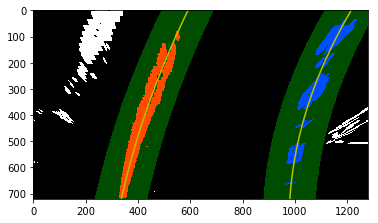

In [437]:
# We can now use the results of this fit, to predict which pixels will be lane lines in the next frame.
# assume we receive a new warped image

# 1. Read in a new image (jpg format) using mpimg. And send it through the pipeline (undistort, threshold, warp). Get an output
# binary warped image.
# 2. Now assuming this is the very first image, send it through the finding lane lines function. Which will return a fit for
# the right lane line and left lane line. As well as any other information , such as left lane indices and right lane indices.
# 3. Now create another function which takes as input, a binary warped image and left fit and right fit coefficients.
# 4. Finally take all these functions and properties and create a class called Lines().
def find_lane_lines_previous_fit(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    predxleft = (left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2])
    predxright = (right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2])
    left_lane_inds = ((nonzerox > predxleft - margin) & (nonzerox < predxleft + margin))
    right_lane_inds = ((nonzerox > predxright - margin) & (nonzerox< predxright + margin))
    
    # Get the new lane pixel positions
    lefty = nonzeroy[left_lane_inds]
    leftx = nonzerox[left_lane_inds]
    righty = nonzeroy[right_lane_inds]
    rightx = nonzerox[right_lane_inds]
    
    # Now we can find a new fit
    left_fit_new = np.polyfit(lefty, leftx, 2)
    right_fit_new = np.polyfit(righty, rightx, 2)
    
    # Let us plot it like how we did before
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit_new[0]*ploty**2 + left_fit_new[1]*ploty + left_fit_new[2]
    right_fitx = right_fit_new[0]*ploty**2 + right_fit_new[1]*ploty + right_fit_new[2]
    
    # For future radius of curvature calculations, lets find left_fitcr and right_fitcr
    ym_per_pix = 30/720
    xm_per_pix = 3.7/600
    left_fitcr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fitcr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Visualize window, lane pixels and polynomial fit line on an output image
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    window_img = np.zeros_like(out_img)
    # Color the left and right lane pixels
    out_img[lefty, leftx] = (255, 0, 0)
    out_img[righty, rightx] = (0, 0, 255)
    # Define the left and right lines of the window, and create points which we can use in cv2.fillPoly
    window_leftline1= np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
    # For the line2 of left lane, we need to flip the array upside down, so as to continue from the bottom to top in order!
    window_leftline2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((window_leftline1, window_leftline2))
    window_rightline1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
    # similarly for line 2 of right lane
    window_rightline2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
    right_line_pts = np.hstack((window_rightline1, window_rightline2))
    
    
    
    cv2.fillPoly(window_img, np.int_(left_line_pts), (0, 255, 0))
    cv2.fillPoly(window_img, np.int_(right_line_pts), (0, 255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    print(result.shape)
    plt.imshow(result)#, plt.show()
    plt.plot(left_fitx, ploty, 'y')
    plt.plot(right_fitx, ploty, 'y')
    plt.xlim([0, 1280]), plt.ylim([720, 0])
find_lane_lines_previous_fit(warped, left_fit, right_fit) 
# My attempt at using cv2.fillPoly
# Left lane, get the 4 corner points.

topleftx1 = [left_fitx[0]]

In [442]:
# Calculating the radius of curvature
def radius_of_curvature(left_fitcr, right_fitcr, y_eval = 719):
    ym_per_pix = 30/720
    left_curve_rad = ((1 + (2*left_fitcr[0]*y_eval*ym_per_pix + left_fitcr[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curve_rad = ((1 + (2*right_fitcr[0]*y_eval*ym_per_pix + right_fitcr[1])**2)**1.5) / np.absolute(2*right_fitcr[0])
    print("The radius of curvature is:", left_curve_rad, "m", right_curve_rad, "m")
